## ML Model Data Pipeline
Created by Vincent Lao.

### Function of Pipeline:

Given a dataset, y variable column name, and a defined model (e.g. LinearRegression()), do the following:  
1. Split the data into training and testing data.
2. Train the model on the training set, and predict on the test set.
3. Calculate the MSE, and plot some diagnostics.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.preprocessing import StandardScaler

In [108]:
# run the test harness for evaluating a model
def run_model_pipeline(data, y_col, model, test_size=0.2, random_state=100, diagnostics = False):

    print('Splitting data...')
    X = data.loc[:, data.columns != y_col]
    y = data[y_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, \
                                                        test_size=test_size, \
                                                        random_state=random_state)
    # fit model with scikit-learn
    print('Fitting Model...')
    model.fit(X_train, y_train)

    # evaluate model
    preds = model.predict(X_test)
    mse = mean_squared_error(preds, y_test.values)
    print('[MSE:', str(np.round(mse, 4)) + ']')
    
    r_2 = model.score(X_test, y_test)
    print('[R^2:', str(r_2) + ']')
    
    # need to fix
    if diagnostics:
        summarize_diagnostics(preds, y_test)

    print('----FINISHED----')
    
    return model

# plot diagnostic learning curves
def summarize_diagnostics(preds, y_test):
    
    df = pd.DataFrame({'preds' : preds, 'resids' : y_test - preds}).sort_values('preds')

    # plot residuals
    plt.title('Fitted Values vs. Residuals')
    plt.scatter(df['preds'], df['resids'], color='blue')
    plt.ylabel('Residual')
    plt.xlabel('Fitted Values')

    # save plot to file
#     plt.savefig('../../visualizations/diagnostic_plot_vl.png')
#     plt.close()

Splitting data...
Fitting Model...
[MSE: 80493.3654]
[R^2: 0.41471900924150895]
----FINISHED----


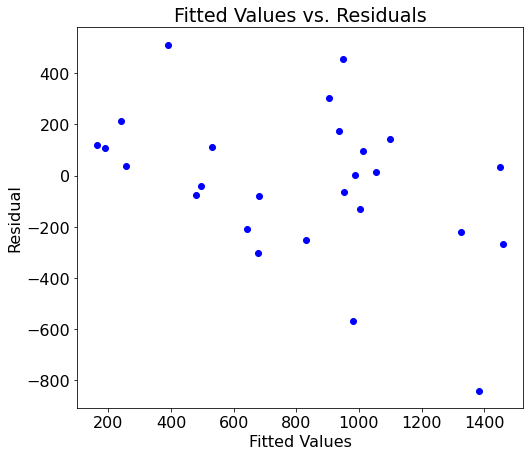

In [202]:
# model = LinearRegression()
# fittedmodel = run_model_pipeline(food2, 'totalco2', model, diagnostics=True)

In [160]:
def get_X_y_stnd(df, y_col, test_size, random_state):
    """
    This function returns four dataframes containing the testing and training X and y values used in land-use regression.
    It standardizes the X variables prior to splitting the data.
    Input: df, a Pandas dataframe with all of the fields in the land-use regression dataset; 
        cols_to_drop, a list of the names (strings) of the columns to drop from df in order to obtain the feature variables.
        y_col, a column name (as a string) of df that represents the response variable
        test_prop, a float between 0 and 1 indicating the fraction of the data to include in the test split
        rand_seed, an integer, used to define the random state
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    # YOUR CODE HERE
    X = df.drop(columns=y_col)
    y = df[y_col]
    
    scaler = StandardScaler() # Initialize the StandardScaler
    scaler.fit(X) # Fit the standard scaler for each feature
    X_stnd = scaler.transform(X) # Standardize each feature
    
    X_train, X_test, y_train, y_test = train_test_split(X_stnd, y, test_size = test_size, random_state = random_state)
    
    return X_train, X_test, y_train, y_test

In [197]:
def linreg_kfold_cv(ModelCV, X_train, X_test, y_train, y_test, alphas, random_state=100, diagnostics=False):
    kf = KFold(shuffle=True, random_state=100)
    cv = ModelCV(cv = kf, alphas = alphas)
    cv.fit(X_train, y_train)
    
    alpha_opt = cv.alpha_
    print("optimal alpha:", alpha_opt)
    
    y_pred_cv = cv.predict(X_test)
    
    cv_mse = mean_squared_error(y_test, y_pred_cv)
    print("Test MSE with cross-validated", re.findall(r'\w{5}CV', str(ModelCV))[0] + ":", cv_mse)
    
    r_2 = cv.score(X_test, y_test)
    print('[R^2:', str(r_2) + ']')
    
    if diagnostics:
        summarize_diagnostics(y_pred_cv, y_test)

optimal alpha: 20
Test MSE with cross-validated LassoCV: 74279.95066458675
[R^2: 0.4598978078425796]


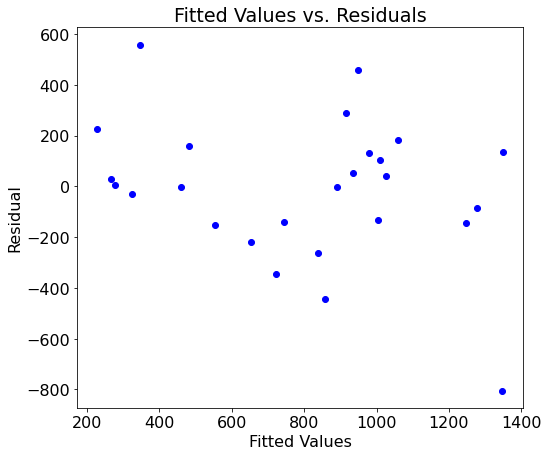

In [203]:
# X_train, X_test, y_train, y_test = get_X_y_stnd(food2, 'totalco2', \
#                                                     test_size=0.2, \
#                                                     random_state=100)

# alphas = [1, 10, 20, 30, 40, 50, 100]
# linreg_kfold_cv(LassoCV, X_train, X_test, y_train, y_test, alphas, random_state=100, diagnostics=True)

optimal alpha: 20
Test MSE with cross-validated RidgeCV: 73976.5469840636
[R^2: 0.46210390775908505]


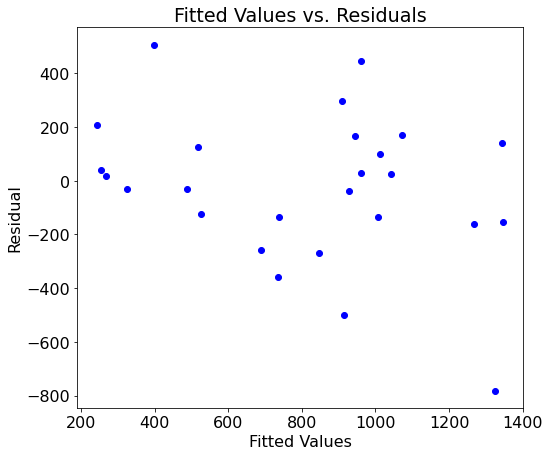

In [200]:
# linreg_kfold_cv(RidgeCV, X_train, X_test, y_train, y_test, alphas, random_state=100, diagnostics=True)

Splitting data...
Fitting Model...
[MSE: 80493.3654]
[R^2: 0.41471900924150895]
----FINISHED----


LinearRegression()

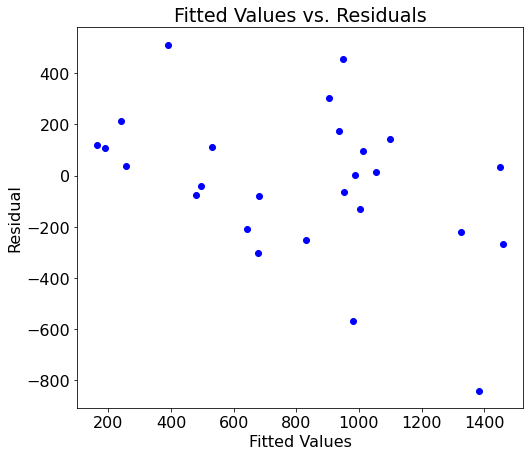

In [201]:
# run_model_pipeline(food2, 'totalco2', LinearRegression(), diagnostics=True)

---

### Recreating the lm() function from R in Python using statsmodels

In [ ]:
from matplotlib import rcParams
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.nonparametric.smoothers_lowess import lowess
import numpy as np
import scipy.stats as stats

In [89]:
# code from here: https://towardsdatascience.com/going-from-r-to-python-linear-regression-diagnostic-plots-144d1c4aa5a

def plot_residuals_vs_fitted(results):
    '''
    Given a fitted statsmodels.OLS model, graph the residuals vs. fitted data. Code taken from link above.
    '''
    residuals = results.resid
    fitted = results.fittedvalues
    smoothed = lowess(residuals,fitted)
    top3 = abs(residuals).sort_values(ascending = False)[:3]

    plt.rcParams.update({'font.size': 16})
    plt.rcParams["figure.figsize"] = (8,7)
    fig, ax = plt.subplots()
    ax.scatter(fitted, residuals, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Residuals')
    ax.set_xlabel('Fitted Values')
    ax.set_title('Residuals vs. Fitted')
    ax.plot([min(fitted),max(fitted)],[0,0],color = 'k',linestyle = ':', alpha = .3)

    for i in top3.index:
        ax.annotate(i,xy=(fitted[i],residuals[i]))

In [90]:
def qqplot(results):
    '''
    Given a fitted statsmodels.OLS model, graph the normal Q-Q plot. Code taken from link above.
    '''
    sorted_student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    sorted_student_residuals.index = results.resid.index
    sorted_student_residuals = sorted_student_residuals.sort_values(ascending = True)
    df = pd.DataFrame(sorted_student_residuals)
    df.columns = ['sorted_student_residuals']
    df['theoretical_quantiles'] = stats.probplot(df['sorted_student_residuals'], dist = 'norm', fit = False)[0]
    rankings = abs(df['sorted_student_residuals']).sort_values(ascending = False)
    top3 = rankings[:3]

    fig, ax = plt.subplots()
    x = df['theoretical_quantiles']
    y = df['sorted_student_residuals']
    ax.scatter(x,y, edgecolor = 'k',facecolor = 'none')
    ax.set_title('Normal Q-Q')
    ax.set_ylabel('Standardized Residuals')
    ax.set_xlabel('Theoretical Quantiles')
    ax.plot([np.min([x,y]),np.max([x,y])],[np.min([x,y]),np.max([x,y])], color = 'r', ls = '--')
    for val in top3.index:
        ax.annotate(val,xy=(df['theoretical_quantiles'].loc[val],df['sorted_student_residuals'].loc[val]))
    plt.show()

In [91]:
def plot_leverage(results):
    '''
    Given a fitted statsmodels.OLS model, graph the residuals vs. leverage plot. Code taken from link above.
    '''
    student_residuals = pd.Series(results.get_influence().resid_studentized_internal)
    student_residuals.index = results.resid.index
    df = pd.DataFrame(student_residuals)
    df.columns = ['student_residuals']
    df['leverage'] = results.get_influence().hat_matrix_diag
    smoothed = lowess(df['student_residuals'],df['leverage'])
    sorted_student_residuals = abs(df['student_residuals']).sort_values(ascending = False)
    top3 = sorted_student_residuals[:3]

    fig, ax = plt.subplots()
    x = df['leverage']
    y = df['student_residuals']
    xpos = max(x)+max(x)*0.01  
    ax.scatter(x, y, edgecolors = 'k', facecolors = 'none')
    ax.plot(smoothed[:,0],smoothed[:,1],color = 'r')
    ax.set_ylabel('Studentized Residuals')
    ax.set_xlabel('Leverage')
    ax.set_title('Residuals vs. Leverage')
    ax.set_ylim(min(y)-min(y)*0.15,max(y)+max(y)*0.15)
    ax.set_xlim(-0.01,max(x)+max(x)*0.05)
    plt.tight_layout()
    for val in top3.index:
        ax.annotate(val,xy=(x.loc[val],y.loc[val]))

    cooksx = np.linspace(min(x), xpos, 50)
    p = len(results.params)
    poscooks1y = np.sqrt((p*(1-cooksx))/cooksx)
    poscooks05y = np.sqrt(0.5*(p*(1-cooksx))/cooksx)
    negcooks1y = -np.sqrt((p*(1-cooksx))/cooksx)
    negcooks05y = -np.sqrt(0.5*(p*(1-cooksx))/cooksx)

    ax.plot(cooksx,poscooks1y,label = "Cook's Distance", ls = ':', color = 'r')
    ax.plot(cooksx,poscooks05y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks1y, ls = ':', color = 'r')
    ax.plot(cooksx,negcooks05y, ls = ':', color = 'r')
    ax.plot([0,0],ax.get_ylim(), ls=":", alpha = .3, color = 'k')
    ax.plot(ax.get_xlim(), [0,0], ls=":", alpha = .3, color = 'k')
    ax.annotate('1.0', xy = (xpos, poscooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, poscooks05y[-1]), color = 'r')
    ax.annotate('1.0', xy = (xpos, negcooks1y[-1]), color = 'r')
    ax.annotate('0.5', xy = (xpos, negcooks05y[-1]), color = 'r')
    ax.legend()
    plt.show()

In [98]:
# using statsmodels 

# X = sm.add_constant(food2.loc[:, food2.columns != 'totalco2']).drop(columns='soybeansupply_pct')
# y = food2['totalco2']

# X_train, X_test, y_train, y_test = train_test_split(X, y, \
#                                                         test_size=0.2, \
#                                                         random_state=100)

# model = sm.OLS(y_train, X_train)
# results = model.fit()